<a href="https://colab.research.google.com/github/OllyMuh/Python_for_DataScience/blob/course_work/ollymuh_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# курсовой проект по теме "Real Estate Price Prediction"

#### Этот ноутбук создан на основе ноутбука baseline (https://www.kaggle.com/julichitai/baseline)

### **Содержание**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# размер шрифта 14
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/test.csv'


#TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
#TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

In [ ]:
# функция отображения полученных значений и расчета метрики R2
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    # R2 metric
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    #train values
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    #test values
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [ ]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [ ]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [ ]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [ ]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [ ]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [ ]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

In [ ]:
# describe train dataframe variables
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Целевая переменная**

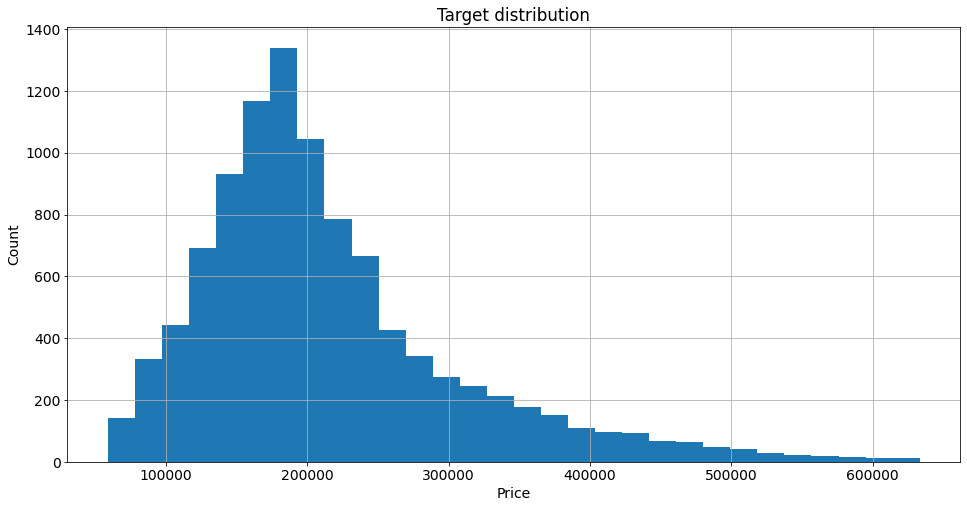

In [ ]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [ ]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)   # без цены
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53fa72c250>,
      dtype=object)

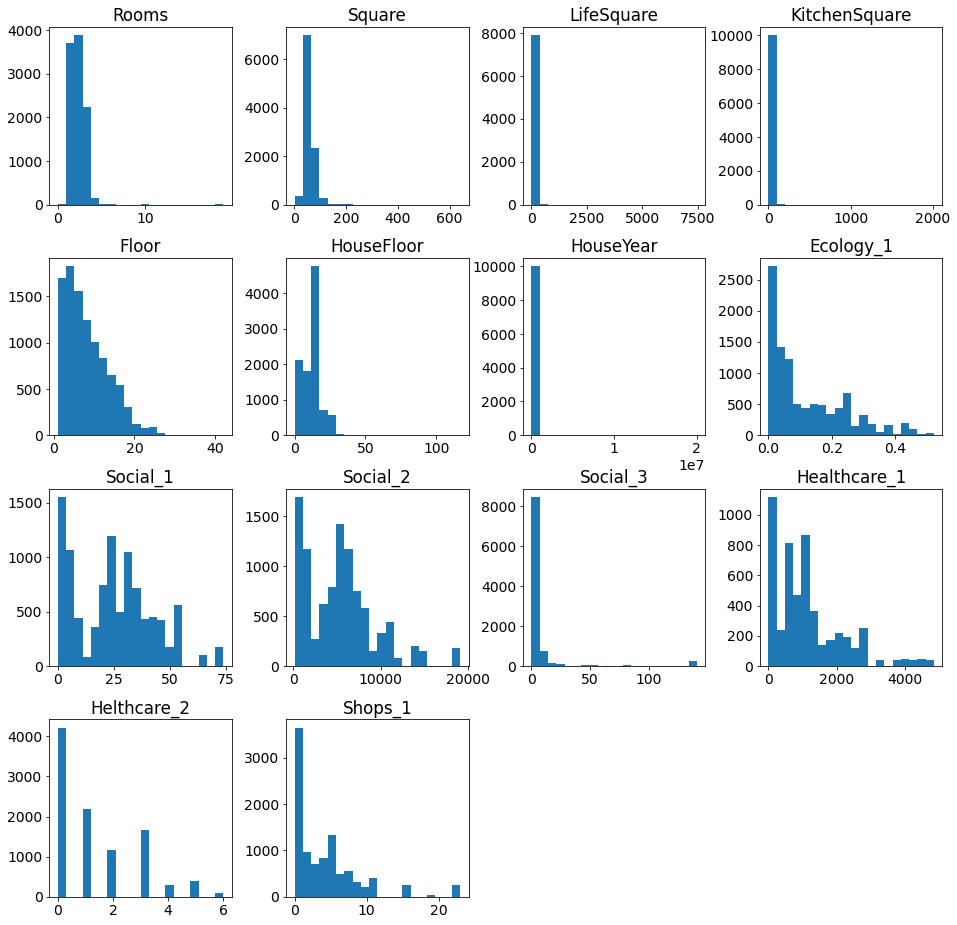

In [ ]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

**Rooms**

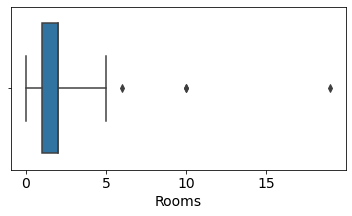

In [ ]:
plt.figure(figsize=(6,3))

sns.boxplot(train_df['Rooms'], whis=3)
plt.xlabel('Rooms')
plt.show()

В признаке не может быть количество комнат 0, количество комнат свыше 5 - выбросы

**Square**

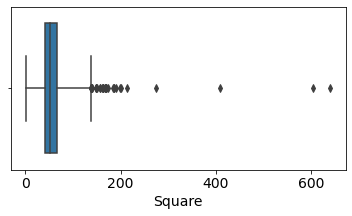

In [ ]:
plt.figure(figsize=(6,3))

sns.boxplot(train_df['Square'], whis=3)
plt.xlabel('Square')
plt.show()

Площадь квартиры не может быть 0, площадь свыше 150 метров - выбросы

**LifeSquare**

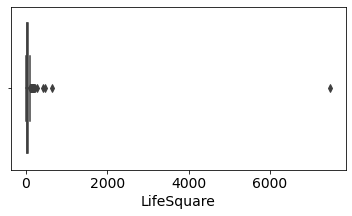

In [ ]:
plt.figure(figsize=(6,3))

sns.boxplot(train_df['LifeSquare'], whis=3)
plt.xlabel('LifeSquare')
plt.show()

In [ ]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

Значения близкие к 0 и 7480 - точно выбросы

**KitchenSquare**

In [ ]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

Площадь кухни не может быть 0 и не может быть 2014 м.кв.

**Площадь квартиры меньше жилой площади**

In [ ]:
train_df.loc[train_df['Square'] < train_df['LifeSquare']]
#482 rows

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
77,11771,45,1.0,38.467276,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698


**Количество этажей в доме = 0**

In [ ]:
train_df.loc[train_df['HouseFloor'] == 0]
# 269 rows

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
152,12947,53,2.0,56.023342,NaN,0.0,14,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.564832
159,13146,74,1.0,46.449711,NaN,0.0,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.450148
186,12174,62,1.0,44.954880,NaN,0.0,8,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.301722
229,15661,45,3.0,81.094922,NaN,0.0,15,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.456032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,NaN,0.0,2,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,129674.841139
9931,15686,1,1.0,47.402412,NaN,0.0,14,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,174740.301224
9940,4711,6,1.0,41.224118,NaN,0.0,8,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.639104
9950,5383,48,3.0,98.994909,NaN,0.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446


**Этаж квартиры больше, чем количество этажей в здании**

In [ ]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']]
#1825 rows

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184


**Номинативные переменные**

In [ ]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [ ]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [ ]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [ ]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [ ]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

**1. Rooms обработка выбросов**

In [ ]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [ ]:
# Выделяем в отдельный признак "Rooms_outlier" со значением 1 для выбросов
train_df['Rooms_outliers'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outliers'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliers
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [ ]:
# Заменяем значение 0 комнат на 1 комнату, значения свыше 5 комнат на медианное
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [ ]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

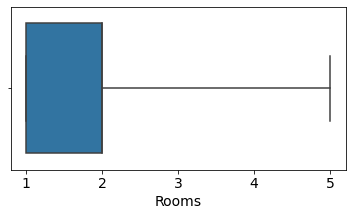

In [ ]:
plt.figure(figsize=(6,3))

sns.boxplot(train_df['Rooms'], whis=3)
plt.xlabel('Rooms')
plt.show()

**2. Square обработка выбросов**

In [ ]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [ ]:
# с помощью квантилей определяем минимальное и максимальное значения для большинства объектов - 98.5% и 1.5%
train_df['Square'].quantile(.985), train_df['Square'].quantile(.015)

(107.93015256122816, 30.94596121794909)

In [ ]:
# помечаем такие ячейки
train_df['Square_outliers'] = 0
train_df.loc[(train_df['Square'] > 150) | (train_df['Square'] < 30), 'Square_outliers'] = 1

In [ ]:
# заменяем значения выбросов (площадь больше 150 м кв) медианным значением
train_df.loc[train_df['Square'] > 150, 'Square'] = train_df['Square'].median()
# заменяем значения выбросов (площадь меньше 30 м кв) медианным значением
train_df.loc[train_df['Square'] < 30, 'Square'] = train_df['Square'].median()

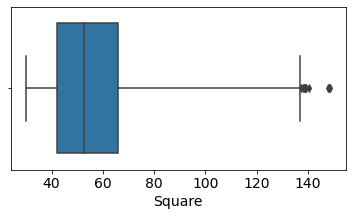

In [ ]:
plt.figure(figsize=(6,3))

sns.boxplot(train_df['Square'], whis=3)
plt.xlabel('Square')
plt.show()

**3. LifeSquare обработка выбросов**

In [ ]:
# с помощью квантилей 97.5% и 3% определяем минимальное и максимальное значения выборки объектов
train_df['LifeSquare'].quantile(.975), train_df['LifeSquare'].quantile(.03)
# 80.748, 14.524
# площадь свыше 80 м.кв. и меньше 14 м.кв. - выбросы

(80.74810407514713, 14.524808682119971)

In [ ]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [ ]:
# помечаем такие ячейки
train_df['LifeSquare_outliers'] = 0
train_df.loc[(train_df['LifeSquare'] > 80) | (train_df['LifeSquare'] < 14), 'LifeSquare_outliers'] = 1

In [ ]:
# заменяем значения выбросов (жилая площадь больше 80 м кв) медианным значением
train_df.loc[train_df['LifeSquare'] > 80, 'LifeSquare'] = train_df['LifeSquare'].median()
# заменяем значения выбросов (жилая площадь меньше 14 м кв) медианным значением
train_df.loc[train_df['LifeSquare'] < 14, 'LifeSquare'] = train_df['LifeSquare'].median()

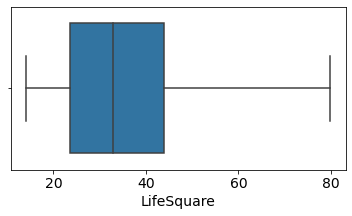

In [ ]:
plt.figure(figsize=(6,3))

sns.boxplot(train_df['LifeSquare'], whis=3)
plt.xlabel('LifeSquare')
plt.show()

**4. KitchenSquare обработка выбросов** 

In [ ]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [ ]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [ ]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

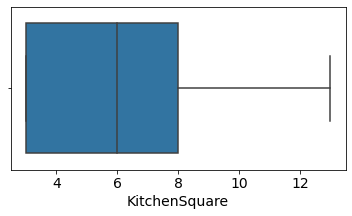

In [ ]:
plt.figure(figsize=(6,3))

sns.boxplot(train_df['KitchenSquare'], whis=3)
plt.xlabel('KitchenSquare')
plt.show()

**5. HouseFloor, Floor обработка выбросов**

In [ ]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [ ]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [ ]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [ ]:
# помечаем объекты, в которых количество этажей в здании 0 и этаж квартиры больше этажа здания
train_df['HouseFloor_outliers'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outliers'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outliers'] = 1

In [ ]:
# заменяем нулевые значения этажности здания медианными
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [ ]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [ ]:
# заменяем значения этажа квартиры, которые выше этажности здания, случайным значением этажа в этом здании
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [ ]:
# проверка есть ли такие квартиры
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**6. HouseYear обработка выбросов**

In [ ]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [ ]:
# заменяем значения больше 2020 на 2020 год
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [ ]:
train_df['HouseYear'].describe()

count    10000.000000
mean      1984.872400
std         18.416347
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

**7. Square, LifeSquare, KitchenSquare сопоставление**

Должно быть Square >= LifeSquare + KitchenSquare

In [ ]:
train_df.loc[train_df['Square'] < train_df['LifeSquare']]
# 379 rows

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliers,Square_outliers,LifeSquare_outliers,HouseFloor_outliers
33,847,74,2.0,73.314975,74.131261,3.0,4,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863,0,0,0,1
77,11771,45,1.0,38.467276,39.624493,3.0,5,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601,0,0,0,1
165,10005,58,1.0,44.995130,47.483236,3.0,1,2.0,2019,0.437885,B,B,23,5735,3,1084.0,0,5,B,106866.248746,0,0,0,1
213,16266,6,2.0,61.735728,62.898664,3.0,16,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,168514.435296,0,0,0,0
262,849,62,2.0,62.869676,64.253870,3.0,1,1.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,158591.394111,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9915,8998,20,1.0,30.082090,32.781260,7.0,9,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,186537.391208,0,0,1,0
9947,8062,6,1.0,41.606714,42.249308,3.0,20,25.0,2017,0.243205,B,B,5,1564,0,540.0,0,0,B,137389.035128,0,0,0,0
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617,0,0,0,0
9979,2201,6,1.0,40.043234,41.984322,3.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598,0,0,0,0


In [ ]:
# помечаем объекты, в которых жилая площадь больше общей
train_df['LifeSquare_outliers'] = 0
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare_outliers'] = 1

In [ ]:
# заменяем значения жилой площади на значения общей площади - площадь кухни - 3 метра
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 3

In [ ]:
# проверяем все ли сработало
train_df.loc[train_df['LifeSquare_outliers'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliers,Square_outliers,LifeSquare_outliers,HouseFloor_outliers
33,847,74,2.0,73.314975,67.314975,3.0,4,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863,0,0,1,1
77,11771,45,1.0,38.467276,32.467276,3.0,5,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601,0,0,1,1
165,10005,58,1.0,44.995130,38.995130,3.0,1,2.0,2019,0.437885,B,B,23,5735,3,1084.0,0,5,B,106866.248746,0,0,1,1
213,16266,6,2.0,61.735728,55.735728,3.0,16,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,168514.435296,0,0,1,0
262,849,62,2.0,62.869676,56.869676,3.0,1,1.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,158591.394111,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9915,8998,20,1.0,30.082090,20.082090,7.0,9,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,186537.391208,0,0,1,0
9947,8062,6,1.0,41.606714,35.606714,3.0,20,25.0,2017,0.243205,B,B,5,1564,0,540.0,0,0,B,137389.035128,0,0,1,0
9962,14175,14,1.0,42.029175,29.029175,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617,0,0,1,0
9979,2201,6,1.0,40.043234,34.043234,3.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598,0,0,1,0


### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [ ]:
train_df.isna().sum()

Id                        0
DistrictId                0
Rooms                     0
Square                    0
LifeSquare             2113
KitchenSquare             0
Floor                     0
HouseFloor                0
HouseYear                 0
Ecology_1                 0
Ecology_2                 0
Ecology_3                 0
Social_1                  0
Social_2                  0
Social_3                  0
Healthcare_1           4798
Helthcare_2               0
Shops_1                   0
Shops_2                   0
Price                     0
Rooms_outliers            0
Square_outliers           0
LifeSquare_outliers       0
HouseFloor_outliers       0
dtype: int64

In [ ]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


**LifeSquare обработка пропусков**

Заполняем пропуски разницей между общей площадью и кухней - 3 метра на коридор

In [ ]:
#помечаем объекты с пропусками жилой площади
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1 - удаляем признак (слишком много пропусков)**

In [ ]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

**Создаем класс для предобработки данных**

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.square_quantile_min = None
        self.square_quantile_max = None
        self.kitchen_square_quantile = None
        self.lifesquare_quantile_min = None
        self.lifesquare_quantile_max = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Расчет квантилей
        self.square_quantile_min = X['Square'].quantile(.015)
        self.square_quantile_max = X['Square'].quantile(.985)
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.lifesquare_quantile_min = X['LifeSquare'].quantile(.03)
        self.lifesquare_quantile_max = X['LifeSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # 1. Rooms обработка выбросов
          # помечаем
        X['Rooms_outliers'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outliers'] = 1
          # заменяем на 1 (где был 0) и на медиану
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']


        # 2. Square обработка выбросов
        square_outlier_condition = (X['Square'] > self.square_quantile_max) \
                                    | (X['Square'] < self.square_quantile_min)
          # помечаем
        X['Square_outliers'] = 0
        X.loc[square_outlier_condition, 'Square_outliers'] = 1
          # заменяем на медиану
        X.loc[square_outlier_condition, 'Square'] = self.medians['Square']


        # 3. LifeSquare обработка выбросов
        lifesquare_outlier_condition = (X['LifeSquare'] > self.lifesquare_quantile_max) \
                                    | (X['LifeSquare'] < self.lifesquare_quantile_min)
          # помечаем
        X['LifeSquare_outliers'] = 0
        X.loc[lifesquare_outlier_condition, 'LifeSquare_outliers'] = 1
          # заменяем на медиану
        X.loc[lifesquare_outlier_condition, 'LifeSquare'] = self.medians['LifeSquare']


        # 4. KitchenSquare обработка выбросов
        kitchen_condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
          
          # заменяем 0 и большие значения на медиану
        X.loc[kitchen_condition, 'KitchenSquare'] = self.medians['KitchenSquare']
          # заменяем площадь меньше 3 метров (1 м.кв.) на 3 м.кв.
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        

        # 5. HouseFloor, Floor обработка выбросов
          # помечаем
        X['HouseFloor_outliers'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outliers'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outliers'] = 1

          # заменяем нулевую этажность дома на медиану
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
          # заменяем этажность квартиры выше этажности дома на случайное значение
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # 6. HouseYear обработка выбросов
        current_year = datetime.now().year
          # помечаем
        X['HouseYear_outliers'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outliers'] = 1

          # заменяем значения больше текущего года на текущий год
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year


        # 7. Square < LifeSquare обработка
        condition_fit = X['Square'] < X['LifeSquare']
          # помечаем
        X.loc[condition_fit, 'LifeSquare_outliers'] = 1
        
          # заменяем корректной площадью
        X.loc[condition_fit, 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3

        # 8. Healthcare_1 обработка пропусков - убираем признак
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # 9. LifeSquare обработка пропусков
          # помечаем
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        condition_nan = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
          # заменяем разницей между общей площадью, кухней и еще 3 м.кв.
        X.loc[condition_nan, 'LifeSquare'] = X.loc[condition_nan, 'Square'] - X.loc[condition_nan, 'KitchenSquare'] - 3
        
        # страховка на случай, если будут пропуски в каких-либо других признаках
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>


**Dummies для признаков с 2 значениями (А и В)**

In [ ]:
# заменяем значения А и В признаков Ecology_2, Ecology_3, Shops_2 цифрами 0 и 1
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize**

In [ ]:
# создаем датафрейм, чтобы посмотреть сколько объектов в разных районах
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()
district_size
# 205 rows для замены значений Id районов количеством объектов в них

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,199,1
201,117,1
202,207,1
203,209,1


In [ ]:
# соединяем с основным датафреймом
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliers,Square_outliers,LifeSquare_outliers,HouseFloor_outliers,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,89


**MedPriceByFloorYear**

In [ ]:
# функции для укрупнения (разбивки на категории) значений этажа и года

def floor_to_cat(X):
    # отдельный столбец
    X['floor_cat'] = 0
    # значения категорий для этажности
    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)    # для пустых значений
    return X


def year_to_cat(X):
    # отдельный столбец
    X['year_cat'] = 0
    # категории для года постройки
    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)    # для пустых значений
    return X

In [ ]:
# обрабатываем датафрейм - добавляем категории
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliers,Square_outliers,LifeSquare_outliers,HouseFloor_outliers,LifeSquare_nan,DistrictSize,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,1,851,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,78,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,652,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,0,1,652,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,89,3,5


In [ ]:
# датафрейм со значениями новых признаков
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                             rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,377289.553272
1,1,2,322905.044793
2,1,3,386374.053775
3,1,4,274992.472366
4,2,1,467230.539057


In [ ]:
# объединяем с основным датафреймом
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliers,Square_outliers,LifeSquare_outliers,HouseFloor_outliers,LifeSquare_nan,DistrictSize,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,1,851,6,2,167100.472386
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,78,3,3,192448.500518
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,652,4,1,202046.143358
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,0,1,652,3,4,183469.921382
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,89,3,5,173934.865013


In [ ]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        """Сохранение статистик"""    

        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding for floor, year
        df = X.copy()
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()  # для пустых значений
        
       
    def transform(self, X):
        """Трансформация данных""" 

        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1  # для пустых значений
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding          
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)  # заполняем пустые значения
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [ ]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliers,Square_outliers,LifeSquare_outliers,HouseFloor_outliers,LifeSquare_nan,DistrictSize,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0,0,0,0,1,851,6,2,167100.472386
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0,0,0,0,0,78,3,3,192448.500518
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0,0,0,0,0,652,4,1,202046.143358
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0,0,0,0,1,652,3,4,183469.921382
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0,0,0,0,0,89,3,5,173934.865013


### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

Посмотрим корреляцию признаков

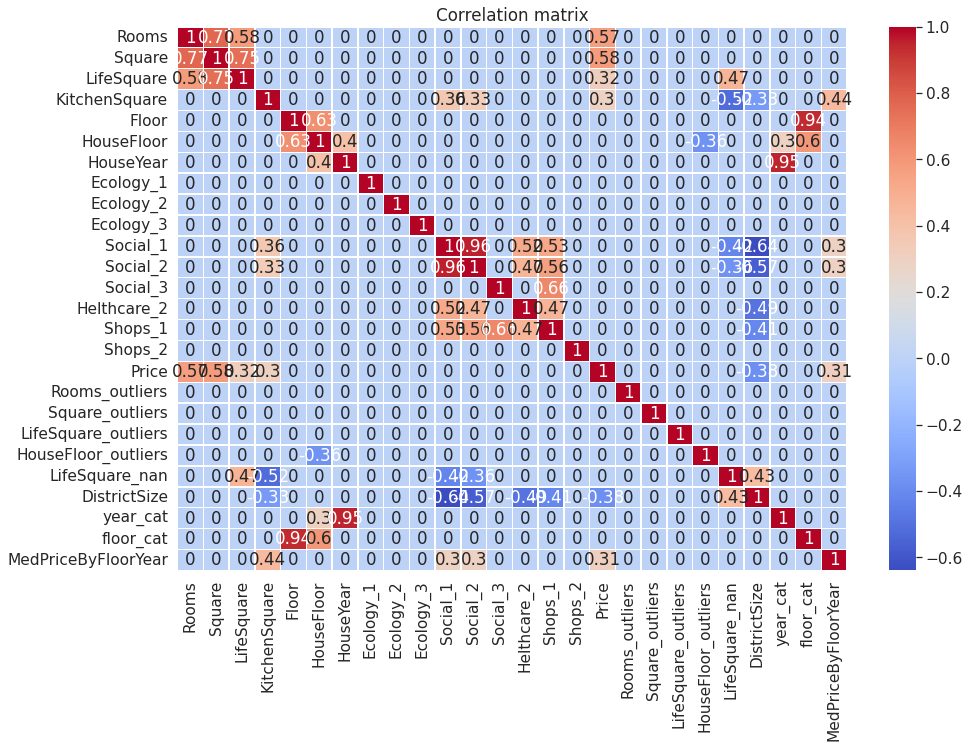

In [ ]:
corr_matrix = train_df.corr()

plt.figure(figsize=(15,10))

sns.set(font_scale=1.4)
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')

plt.show()

In [ ]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outliers',
 'Square_outliers',
 'LifeSquare_outliers',
 'HouseFloor_outliers',
 'LifeSquare_nan',
 'DistrictSize',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [ ]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                  # 'Ecology_1', 'Ecology_2', 'Ecology_3', # не связаны ни с чем
                 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

# new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
#                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

new_feature_names = ['Rooms_outliers', 'HouseFloor_outliers', 'HouseYear_outliers', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'MedPriceByFloorYear']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [ ]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [ ]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**RandomForest**

**Обучение**

In [ ]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', n_estimators=500, max_depth=12, min_samples_leaf=10)
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=12, min_samples_leaf=10,
                      n_estimators=500, random_state=21)

**Оценка модели**

Train R2:	0.785
Test R2:	0.712


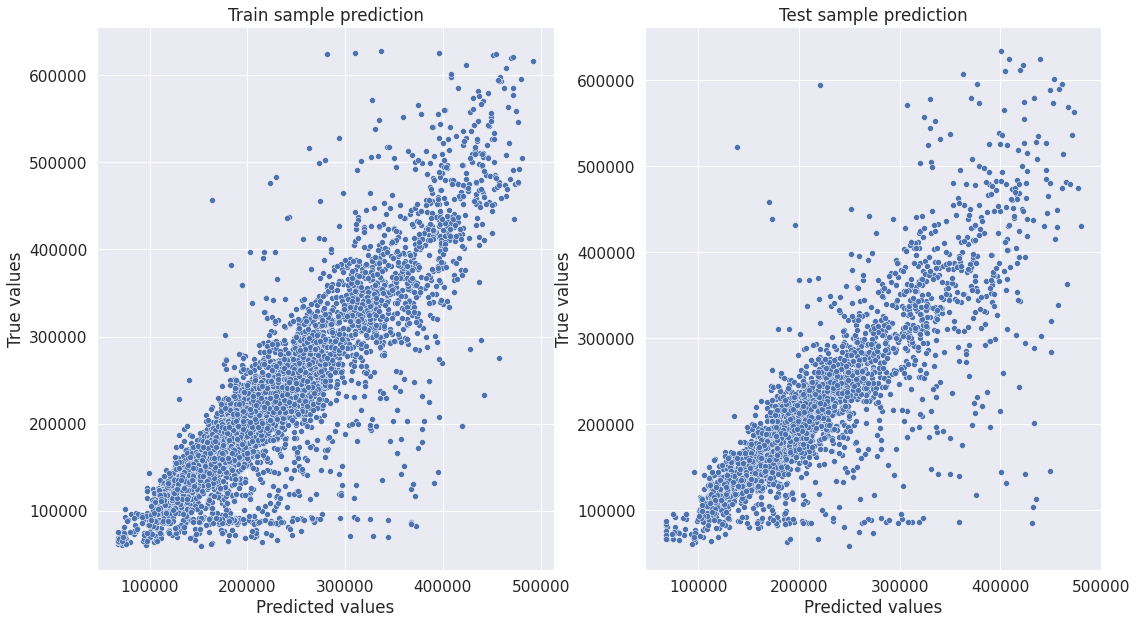

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [ ]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.69000952, 0.62777733, 0.6840553 ])

In [ ]:
cv_score.mean()

0.6672807154998516

Вывод: результат неплохой, почти не переобучивается. Но хотелось бы точнее.

**Важность признаков**

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Rooms,0.313092
1,Square,0.240514
17,DistrictSize,0.204597
9,Social_3,0.056342
6,HouseYear,0.040376
8,Social_2,0.028844
7,Social_1,0.024002
2,LifeSquare,0.021021
19,MedPriceByFloorYear,0.019317
5,HouseFloor,0.016665


**GradientBoosting**

Обучение

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=21,
                                     n_estimators=100
                                     )
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=21)

Оценка модели

Train R2:	0.892
Test R2:	0.736


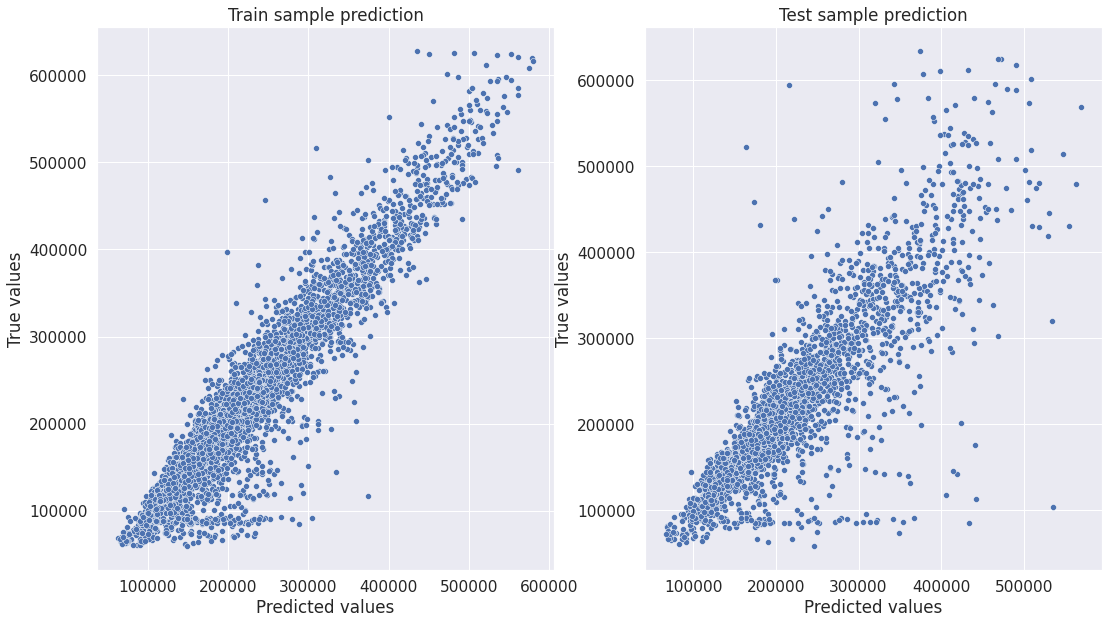

In [ ]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [ ]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.70528327, 0.66686145, 0.70790831])

Вывод: оптимальная модель. Немного переобучивается на трейне (0,892), но тестовый результат выдает выше (0,736). Кросс-валидация тоже получше.

**LinearRegression**

Обучение

In [119]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

LinearRegression()

Оценка модели

Train R2:	0.54
Test R2:	0.53


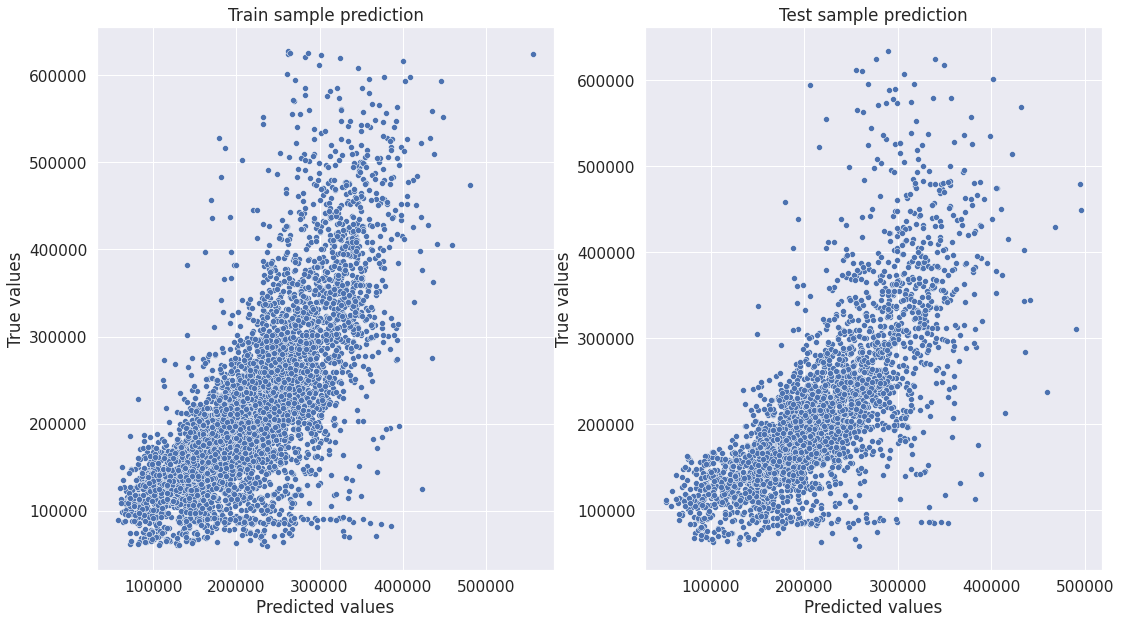

In [120]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Вывод: все как и ожидалось, печально. R2 = 0.54 и 0.53

**BaggingRegressor**

Обучение

In [127]:
from sklearn.ensemble import BaggingRegressor

br_model = BaggingRegressor(n_estimators=100,
                            random_state=42,
                            bootstrap_features=True)

br_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True, n_estimators=100, random_state=42)

Оценка модели

Train R2:	0.958
Test R2:	0.73


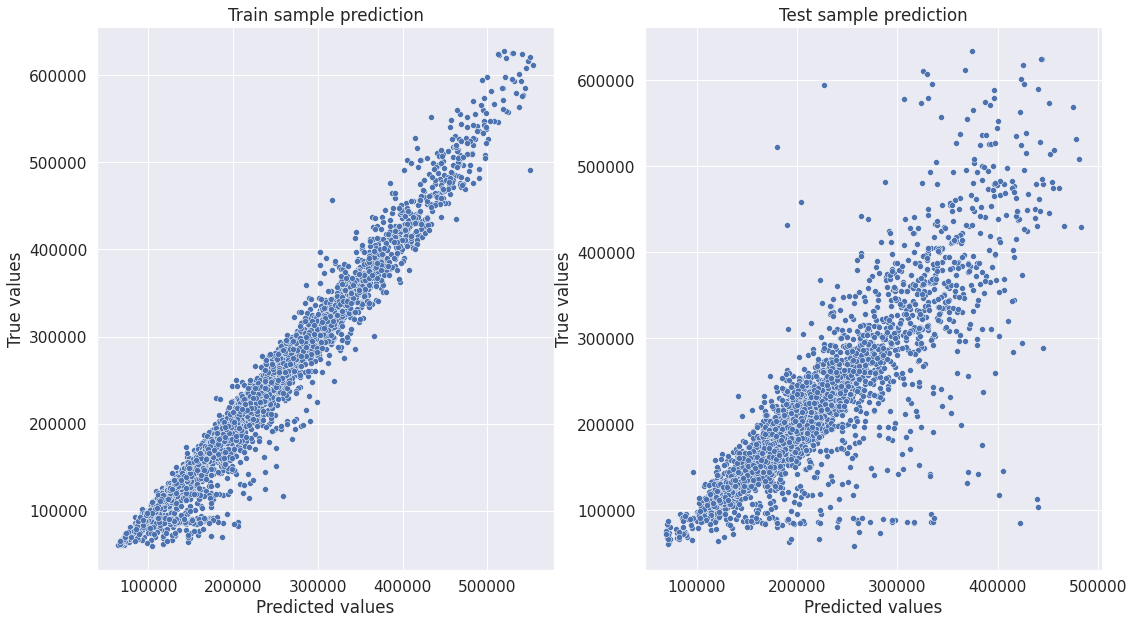

In [128]:
y_train_preds = br_model.predict(X_train)
y_test_preds = br_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [129]:
cv_score = cross_val_score(br_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.71232774, 0.66912563, 0.70336117])

Вывод: результаты почти такие же, как у GradientBoosting. Немного похуже.

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [130]:
test_df.shape

(5000, 20)

In [131]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outliers,HouseFloor_outliers,HouseYear_outliers,LifeSquare_nan,DistrictSize,new_district,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,24,4378,0,1,1,1,0,0,0,0,76.0,0,189115.338060
1,1.0,42.493907,29.493907,10.0,7,17.0,2017,2,629,1,0,0,0,0,0,0,0,164.0,0,177755.781775
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,9,1892,0,0,1,1,0,0,0,1,580.0,0,174513.628600
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,2,475,0,0,0,1,0,0,0,0,372.0,0,179610.110567
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,35,7715,4,0,6,1,0,0,0,1,65.0,0,191867.951499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5,5.0,1962,31,6119,4,1,2,1,0,1,0,0,56.0,0,189115.338060
4996,3.0,93.698122,32.679351,10.0,21,27.0,2018,15,2787,2,0,7,1,0,0,0,0,26.0,0,204011.701682
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,28,6533,1,2,5,1,0,0,0,0,54.0,0,179610.110567
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,33,7976,5,0,11,1,0,0,0,0,40.0,0,191867.951499


In [132]:
# submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit.tail()

,Id,Price
4995,10379,200000.0
4996,16138,200000.0
4997,3912,200000.0
4998,5722,200000.0
4999,11004,200000.0


In [133]:
predictions = gb_model.predict(test_df)
predictions

array([158467.07327425, 122895.7822797 , 145867.00575914, ...,
       147068.17235655, 197357.64977831, 245472.91276626])

In [134]:
submit['Price'] = predictions
submit.tail()

,Id,Price
4995,10379,181525.607597
4996,16138,349467.186791
4997,3912,147068.172357
4998,5722,197357.649778
4999,11004,245472.912766


In [135]:
submit.to_csv('gb_model_submit.csv', index=False)